In [12]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from nhanes.utils import (one_hot_encode, 
                          precision_recall_thershold, 
                          plot_recall_vs_decision_boundary, 
                          plot_multi_recall_vs_decision_boundary,
                          plot_roc_curves,
                          plot_bootstrap_roc,
                          bootstrap_model, 
                          roc_interp,GridSearchCVWrapper)

import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

### Import training and test sets

In [13]:
df_train = pd.read_csv('./data/diabetes_data_train.csv')
df_test = pd.read_csv('./data/diabetes_data_test.csv')

### Check proportion of missing values

In [14]:
df_train.isnull().sum(axis=0)/df_train.shape[0]

Age                                       0.000000
Gender                                    0.000000
Race                                      0.000000
Education                                 0.045768
status                                    0.000000
Smoked at least 100 cigarettes in life    0.001184
Height                                    0.012428
WaistCircumference                        0.048728
BMI                                       0.016374
Hypertension                              0.000000
Thyroid                                   0.047347
PhysicalActivity                          0.006116
SleepDuration                             0.010258
Calories                                  0.213257
Carbs                                     0.213257
Sugar                                     0.213257
TotalFat                                  0.213257
Cholesterol                               0.213257
OCD150                                    0.000197
dtype: float64

### Impute values based on categorical or numerical data type

In [15]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from nhanes.utils import knn_impute_data, handle_categorical_imputation, regression_imputation, post_processing

imp_sleep = df_train['SleepDuration'].mean()

df_train = knn_impute_data(df_train, ['BMI', 'Height', 'PhysicalActivity'])
df_test = knn_impute_data(df_test, ['BMI', 'Height', 'PhysicalActivity'])

categorical_cols = ['Education', 'Thyroid', 'OCD150']
train_imputed, test_imputed = handle_categorical_imputation(df_train, df_test, categorical_cols)

df_train[['Education', 'Thyroid']] = train_imputed[['Education', 'Thyroid']]
df_test[['Education', 'Thyroid']] = test_imputed[['Education', 'Thyroid']]

regression_targets = [
    'WaistCircumference', 'Calories', 'TotalFat', 
    'SleepDuration', 'Carbs', 'Cholesterol', 'Sugar'
]

for target in regression_targets:
    df_train, df_test = regression_imputation(target, df_train, df_test, ['BMI', 'Height'])

df_train = post_processing(df_train, imp_sleep)
df_test = post_processing(df_test, imp_sleep)

In [16]:
df_train.isnull().sum(axis=0)/df_train.shape[0]
df_test.isnull().sum(axis=0)/df_test.shape[0]

Age                                       0.0
Gender                                    0.0
Race                                      0.0
Education                                 0.0
status                                    0.0
Smoked at least 100 cigarettes in life    0.0
Height                                    0.0
WaistCircumference                        0.0
BMI                                       0.0
Hypertension                              0.0
Thyroid                                   0.0
PhysicalActivity                          0.0
SleepDuration                             0.0
Calories                                  0.0
Carbs                                     0.0
Sugar                                     0.0
TotalFat                                  0.0
Cholesterol                               0.0
OCD150                                    0.0
dtype: float64

### One-hot-encode categorical/ordinal variables

In [17]:
continuous_cols = ['Age', 'Height', 'WaistCircumference', 'BMI', 
                  'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 
                  'SleepDuration', 'PhysicalActivity']


Y_train = df_train['status']
Y_test = df_test['status']

df_train.drop(['status'], axis=1, inplace=True) 
df_test.drop(['status'], axis=1, inplace=True)


categorical_cols = [col for col in df_train.columns if col not in continuous_cols ]
print(continuous_cols)
print(categorical_cols)
X_train_categorical = pd.concat(map(lambda col: one_hot_encode(df_train[col], col), categorical_cols), 
                                axis=1)
X_test_categorical = pd.concat(map(lambda col: one_hot_encode(df_test[col], col), categorical_cols),axis=1)

['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity']
['Gender', 'Race', 'Education', 'Smoked at least 100 cigarettes in life', 'Hypertension', 'Thyroid', 'OCD150']


In [18]:
X_train_onehot = pd.concat([X_train_categorical, df_train[continuous_cols]], axis=1)
X_test_onehot = pd.concat([X_test_categorical, df_test[continuous_cols]], axis=1)

In [19]:
train_cols = X_train_onehot.columns

In [20]:
print(X_train_onehot.shape)
print(X_train_onehot.columns)


(5069, 38)
Index(['Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0',
       'Race_6.0', 'Race_7.0', 'Race_nan', 'Education_2.0', 'Education_3.0',
       'Education_4.0', 'Education_5.0', 'Education_nan', 'Education_nan',
       'Smoked at least 100 cigarettes in life_2.0',
       'Smoked at least 100 cigarettes in life_7.0',
       'Smoked at least 100 cigarettes in life_nan', 'Hypertension_2.0',
       'Hypertension_9.0', 'Hypertension_nan', 'Thyroid_2.0', 'Thyroid_nan',
       'Thyroid_nan', 'OCD150_2.0', 'OCD150_3.0', 'OCD150_4.0', 'OCD150_nan',
       'Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs',
       'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration',
       'PhysicalActivity'],
      dtype='object')


In [21]:
categorical_cols = [c for c in train_cols if c not in continuous_cols]
categorical_cols = [col for col in categorical_cols if col not in ['Smoked at least 100 cigarettes in life_9.0', 'OCD150_9.0']]


### SMOTE


In [22]:

from imblearn.over_sampling import SMOTE

df_train.isnull().sum(axis=0)/df_train.shape[0]




smote = SMOTE(sampling_strategy='minority',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_onehot, Y_train)

X_test_resampled, y_test_resampled = smote.fit_resample(X_test_onehot, Y_test)
scale = MinMaxScaler(feature_range=(0, 1)).fit(X_train_resampled[continuous_cols])
X_train_cont_scaled = pd.DataFrame(scale.transform(X_train_resampled[continuous_cols]),
                                   index=X_train_resampled.index,
                                   columns=continuous_cols)
X_test_cont_scaled = pd.DataFrame(scale.transform(X_test_resampled[continuous_cols]),
                                  index=X_test_resampled.index,
                                  columns=continuous_cols)
X_train_scale = pd.concat([X_train_cont_scaled, X_train_resampled[categorical_cols]], axis=1)
X_test_scale = pd.concat([X_test_cont_scaled, X_test_resampled[categorical_cols]], axis=1)

print(X_train_scale.shape,y_train_resampled.shape) #FINAL X AND Y
print(X_test_scale.shape,y_test_resampled.shape)

(8630, 42) (8630,)
(2152, 42) (2152,)


### Feature Seletion

['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity', 'Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0', 'Race_6.0', 'Race_7.0', 'Race_nan', 'Education_2.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_nan', 'Education_nan', 'Education_nan', 'Education_nan', 'Smoked at least 100 cigarettes in life_2.0', 'Smoked at least 100 cigarettes in life_7.0', 'Smoked at least 100 cigarettes in life_nan', 'Hypertension_2.0', 'Hypertension_9.0', 'Hypertension_nan', 'Thyroid_2.0', 'Thyroid_nan', 'Thyroid_nan', 'Thyroid_nan', 'Thyroid_nan', 'OCD150_2.0', 'OCD150_3.0', 'OCD150_4.0', 'OCD150_nan']
Selected features: ['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity', 'Gender_2.0', 'Race_3.0', 'Race_4.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Smoked at least 100 cigarettes in life_2.0',

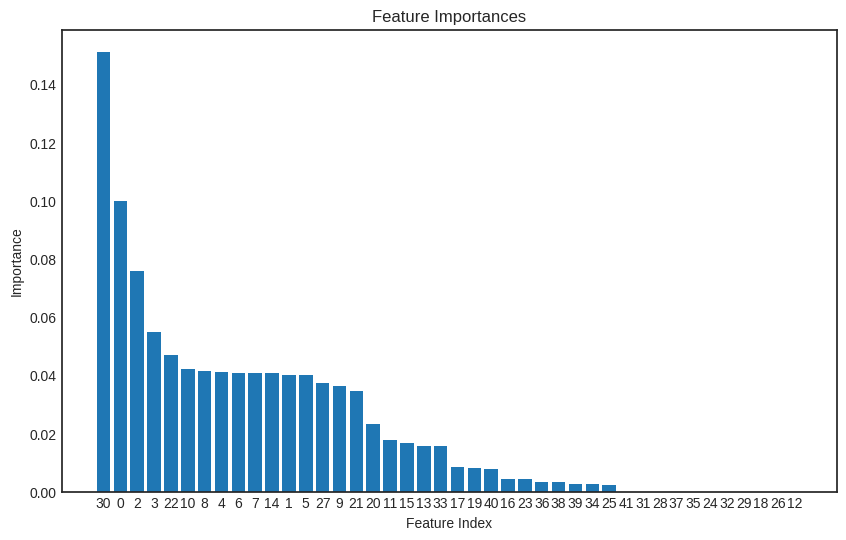

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import numpy as np

# PCA transformation
# pca = PCA(n_components=0.95)  
X_train_pca = X_train_scale.copy()
X_test_pca = X_test_scale.copy()


# Feature selection
selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    max_features=19,
    threshold=-np.inf
)
selector.fit(X_train_pca, y_train_resampled)

selected_indices = selector.get_support(indices=True)
print( list(X_train_pca))
selected_feature_names = [X_train_pca.columns[i] for i in selected_indices]
print("Selected features:", selected_feature_names)

importances = selector.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

selected_features = selector.transform(X_train_pca)
selected_features_test = selector.transform(X_test_pca)




In [25]:
from nhanes.utils import plot_roc

### SVM

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf'}
Best cross-validation score: 0.8543453070683663
Accuracy: 0.828996282527881
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.85      0.83      1076
         1.0       0.84      0.81      0.83      1076

    accuracy                           0.83      2152
   macro avg       0.83      0.83      0.83      2152
weighted avg       0.83      0.83      0.83      2152

Confusion Matrix:
 [[916 160]
 [208 868]]


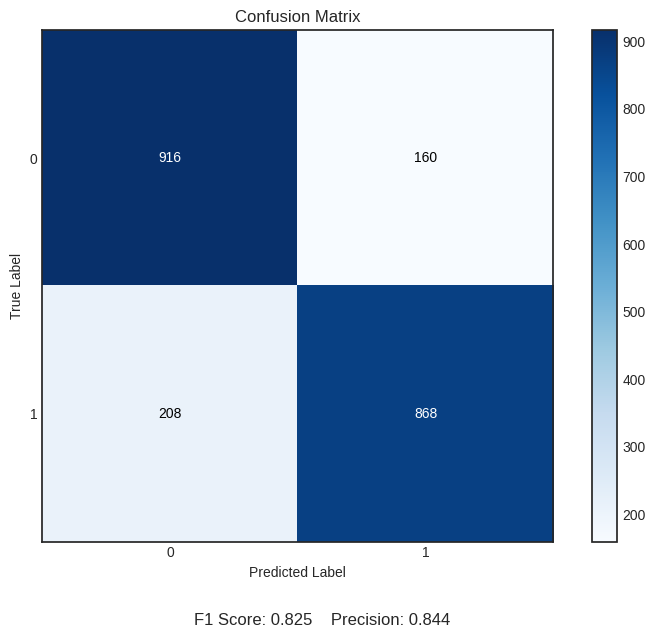

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1.0],  
    'kernel': ['rbf'],    
    'gamma': [1.0],     
    'class_weight': ['balanced', None]  
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42), 
    param_grid,
    cv=5,                     
    scoring='balanced_accuracy',
    n_jobs=-1,                
    verbose=1
)

grid_search.fit(selected_features, y_train_resampled)

svc_best_params = grid_search.best_params_
svc_best_score = grid_search.best_score_

print("Best parameters:", svc_best_params)
print("Best cross-validation score:", svc_best_score)

svc_clf = SVC(**svc_best_params, probability=True).fit(selected_features, y_train_resampled)
plot_roc(selected_features_test,svc_clf,y_test_resampled)

### RandomForest

In [ ]:
import numpy as np

rf_best_params, rf_best_score = GridSearchCVWrapper(
    model=RandomForestClassifier(),
    param_grid=dict(
        criterion=["entropy"],
        min_samples_leaf=[10,15],
        min_samples_split=[2,4],
        max_features=["sqrt"],
        n_jobs=[-1],
    ),
   
    X=selected_features,
    y=y_train_resampled
)
rf_clf = RandomForestClassifier(**rf_best_params).fit(selected_features, y_train_resampled)
plot_roc(selected_features_test,rf_clf,y_test_resampled)



Best Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_jobs': -1}
Best Score: 0.872


NameError: name 'plot_roc' is not defined

### LogisticRegression

/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

Best Params: {'C': 10.0, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.851
Accuracy: 0.8294609665427509
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      1076
         1.0       0.83      0.83      0.83      1076

    accuracy                           0.83      2152
   macro avg       0.83      0.83      0.83      2152
weighted avg       0.83      0.83      0.83      2152

Confusion Matrix:
 [[890 186]
 [181 895]]


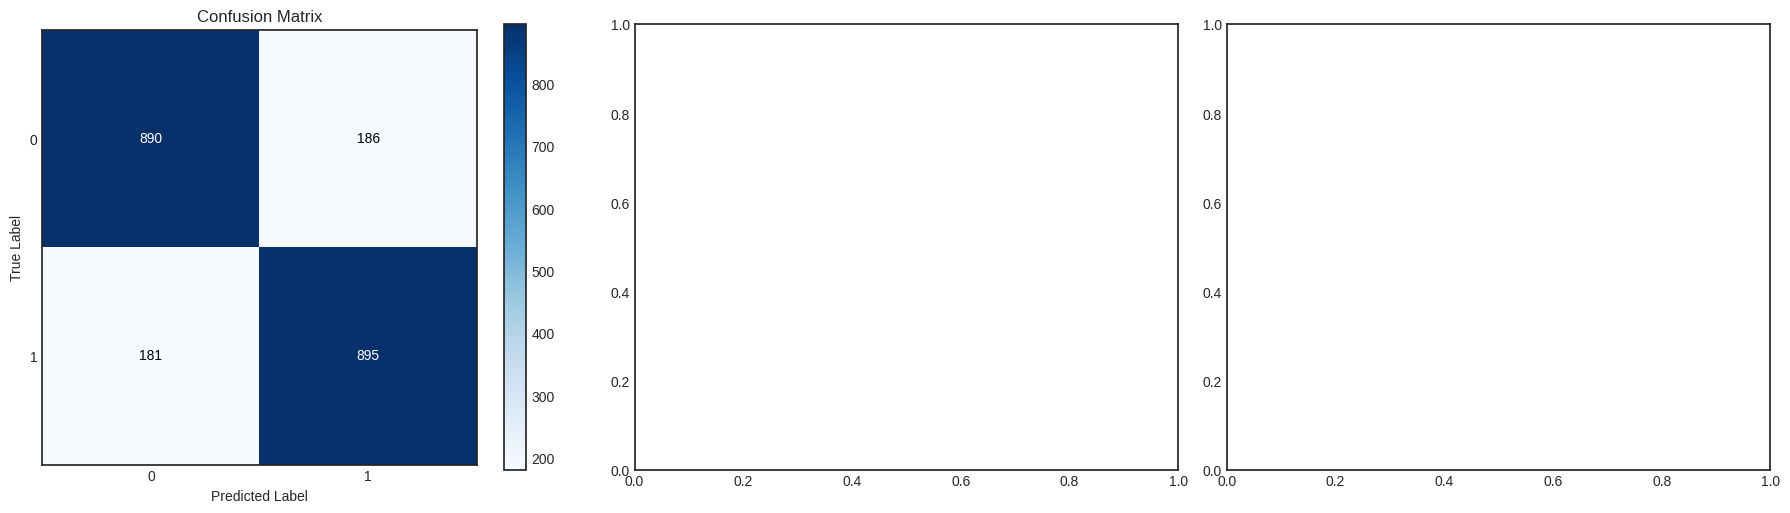

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel


lg_best_params, lg_best_score = GridSearchCVWrapper(
    model=LogisticRegression(),
    param_grid=dict(
        penalty=["elasticnet","l2"],
        l1_ratio=[0.5,0.3,0.7],
        C=[0.001, 0.01, 0.1, 1.0, 10.0],  # Add a range of C values for tuning
        solver=['lbfgs', 'liblinear', 'newton-cholesky']     # Add different solvers for tuning
    ),
    X=selected_features,
    y=y_train_resampled
)

lg_clf = LogisticRegression(**lg_best_params).fit(selected_features, y_train_resampled)
plot_roc(selected_features_test,lg_clf,y_test_resampled)

### KNN

Best Params: {'n_neighbors': 11}
Best Score: 0.849
Accuracy: 0.828996282527881
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      1076
         1.0       0.82      0.84      0.83      1076

    accuracy                           0.83      2152
   macro avg       0.83      0.83      0.83      2152
weighted avg       0.83      0.83      0.83      2152

Confusion Matrix:
 [[879 197]
 [171 905]]


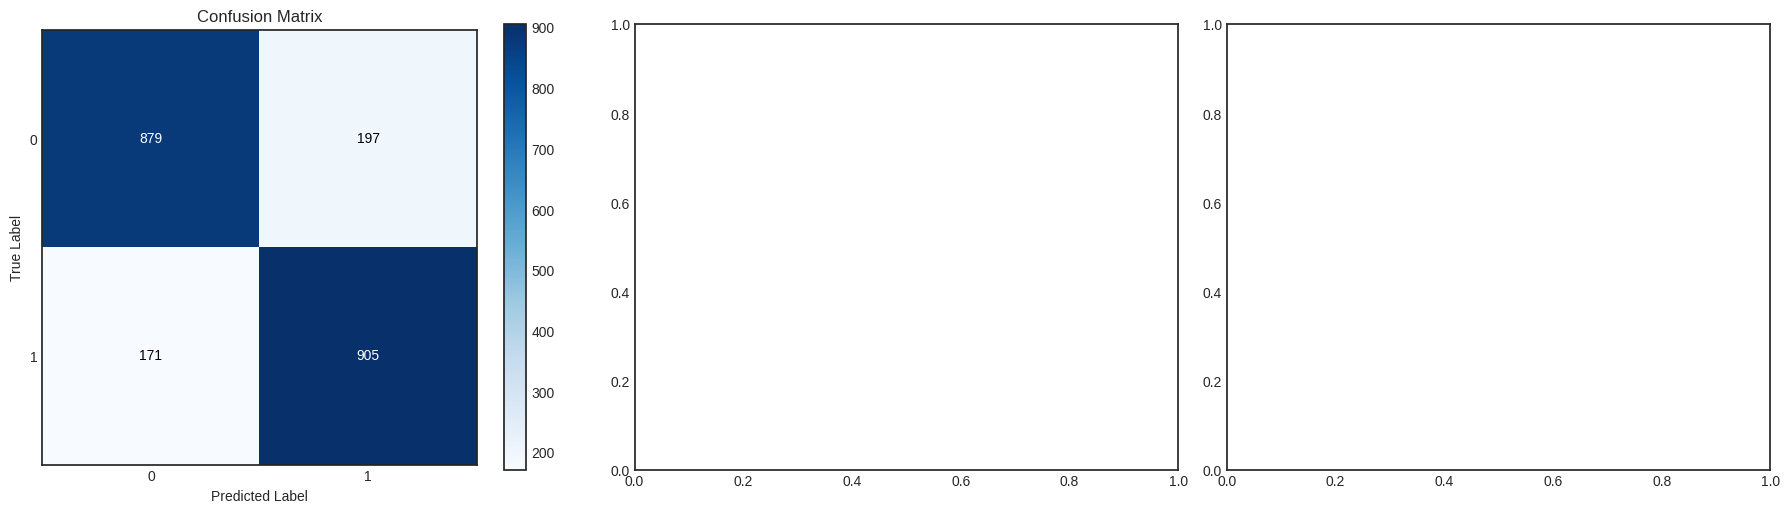

In [22]:
knn_best_params, knn_best_score = GridSearchCVWrapper(
    model=KNeighborsClassifier(),
    param_grid=dict(
        n_neighbors=[11,13,17,23,31,41,53,97]
    ),
    X=selected_features,
    y=y_train_resampled
)


knn_clf = KNeighborsClassifier(**knn_best_params).fit(selected_features, y_train_resampled)
plot_roc(selected_features_test,knn_clf,y_test_resampled)




### GradientBoosting

Best Params: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.865
Accuracy: 0.8671003717472119
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      1076
         1.0       0.87      0.86      0.87      1076

    accuracy                           0.87      2152
   macro avg       0.87      0.87      0.87      2152
weighted avg       0.87      0.87      0.87      2152

Confusion Matrix:
 [[941 135]
 [151 925]]


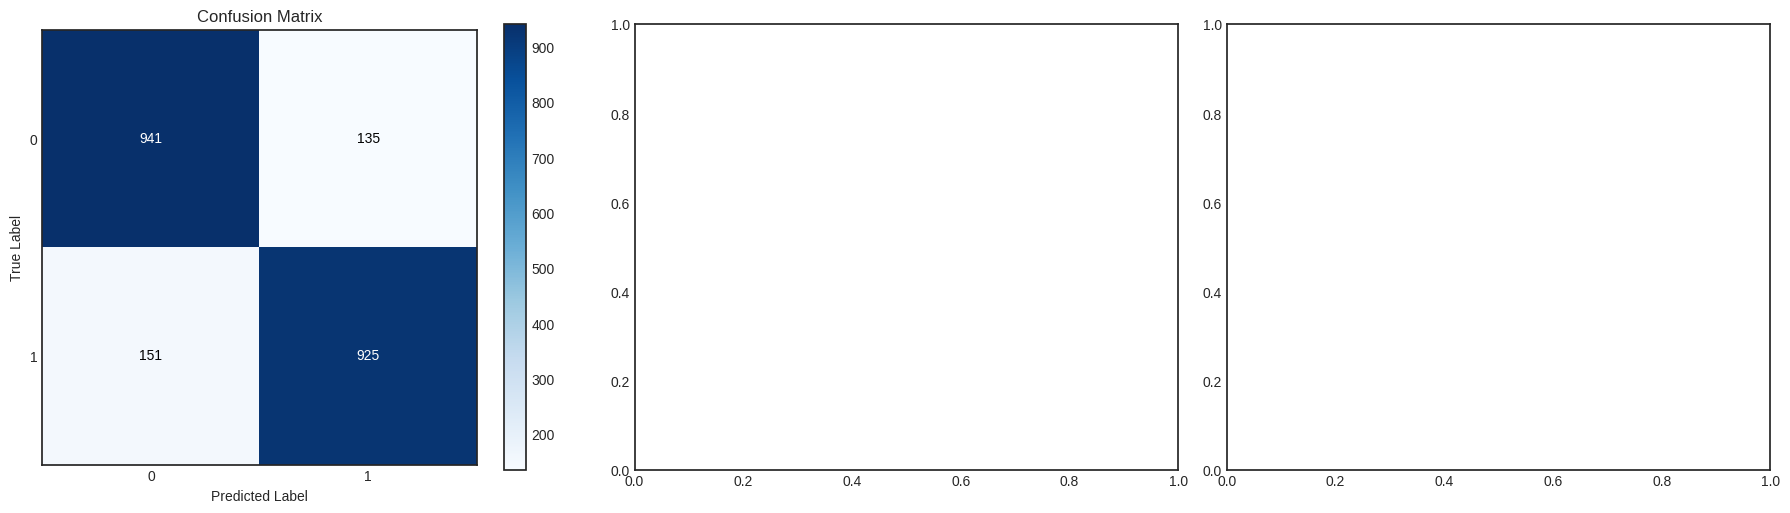

In [23]:
gbc_best_params, gbc_best_score = GridSearchCVWrapper(
    model=GradientBoostingClassifier(),
    param_grid=dict(
        loss=["log_loss"],
        learning_rate=[0.1],
        n_estimators=[100],
        max_depth=[3],
        min_samples_split=[2],
        min_samples_leaf=[1],
        max_features=["sqrt"]
    ),
    X=selected_features,
    y=y_train_resampled
)



gbc_clf = GradientBoostingClassifier(**gbc_best_params).fit(selected_features, y_train_resampled)
plot_roc(selected_features_test,gbc_clf,y_test_resampled)


### Adaboost

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

Best parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation score: 0.8786790266512167
Accuracy: 0.8931226765799256
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1076
         1.0       0.92      0.86      0.89      1076

    accuracy                           0.89      2152
   macro avg       0.90      0.89      0.89      2152
weighted avg       0.90      0.89      0.89      2152

Confusion Matrix:
 [[999  77]
 [153 923]]


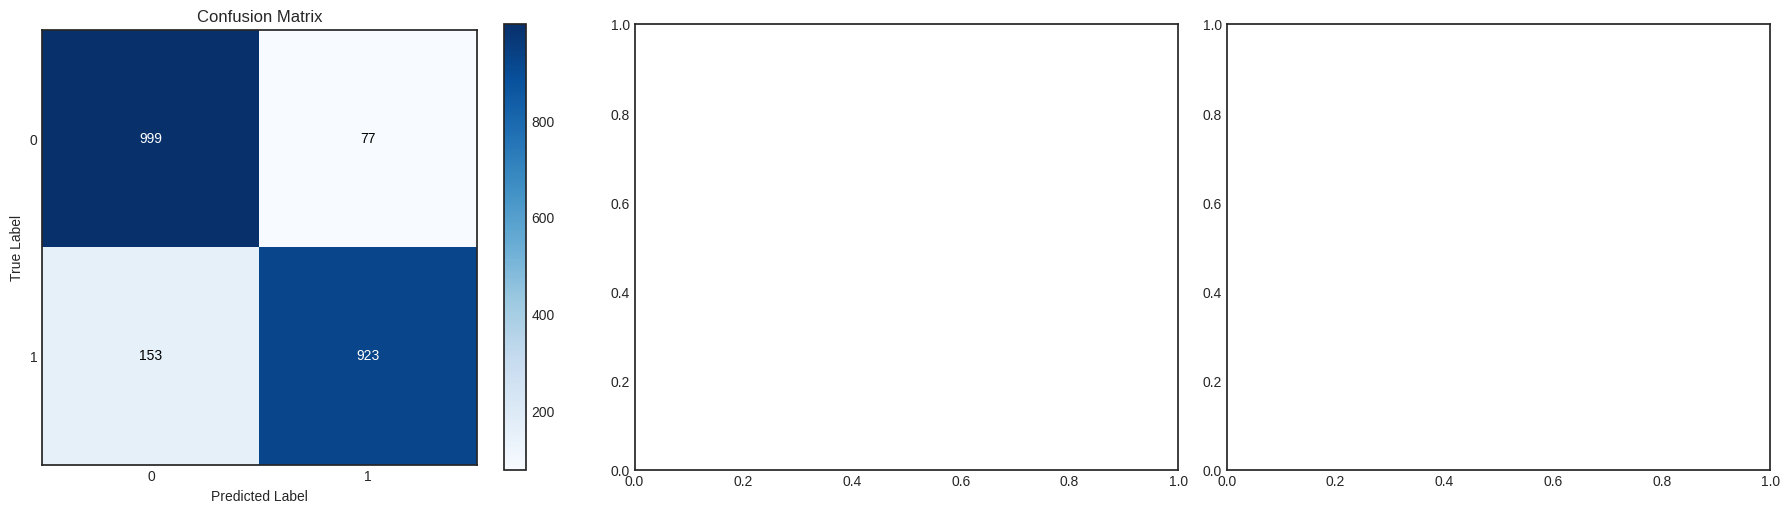

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [ 200],
    'learning_rate': [0.1],
    'base_estimator__max_depth': [3]
}

grid_search = GridSearchCV(
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(selected_features, y_train_resampled)

ada_best_params = grid_search.best_params_
ada_best_score = grid_search.best_score_

print("Best parameters:", ada_best_params)
print("Best cross-validation score:", ada_best_score)

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=ada_best_params['base_estimator__max_depth'], random_state=42),
    n_estimators=ada_best_params['n_estimators'],
    learning_rate=ada_best_params['learning_rate'],
    random_state=42
).fit(selected_features, y_train_resampled)
plot_roc(selected_features_test,ada_clf,y_test_resampled)


### Performance Metrics 

In [28]:
threshold = .5

In [29]:
rf_clf = RandomForestClassifier(**rf_best_params).fit(selected_features, y_train_resampled)
knn_clf = KNeighborsClassifier(**knn_best_params).fit(selected_features, y_train_resampled)
lg_clf = LogisticRegression(**lg_best_params).fit(selected_features, y_train_resampled)


In [30]:
rf_proba  = rf_clf.predict_proba(selected_features_test)
knn_proba = knn_clf.predict_proba(selected_features_test)
lg_proba  = lg_clf.predict_proba(selected_features_test)
svc_proba = svc_clf.predict(selected_features_test)

In [31]:
import numpy as np
from IPython.display import Markdown, display
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Create Ensemble

# print(lg_proba)
# print(gbc_proba)
gbc_proba = gbc_clf.predict_proba(selected_features_test)
svc_proba = svc_clf.predict_proba(selected_features_test)
# print(gbc_proba)
# svc_proba = np.column_stack((svc_proba, 1 - svc_proba))
ada_proba = ada_clf.predict_proba(selected_features_test)

df_preds = pd.DataFrame({
    'RandomForestClassifier': rf_proba[:,1],
    'GradientBoostingClassifier': gbc_proba[:,1],
    'AdaBoost': ada_proba[:,1]
})
df_preds.loc[:,'Ensemble'] = (0.12 * df_preds['RandomForestClassifier'] +
                               0.23 * df_preds['GradientBoostingClassifier'] +
                               0.65  * df_preds['AdaBoost'])





In [32]:
for col in df_preds:
    print(col)
    print(metrics.classification_report(y_test_resampled, np.where(1 - df_preds.loc[:,col] > threshold, 0, 1)))

RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1076
         1.0       0.86      0.83      0.84      1076

    accuracy                           0.85      2152
   macro avg       0.85      0.85      0.85      2152
weighted avg       0.85      0.85      0.85      2152

GradientBoostingClassifier
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      1076
         1.0       0.86      0.86      0.86      1076

    accuracy                           0.86      2152
   macro avg       0.86      0.86      0.86      2152
weighted avg       0.86      0.86      0.86      2152

AdaBoost
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1076
         1.0       0.92      0.86      0.89      1076

    accuracy                           0.89      2152
   macro avg       0.90      0.89      0.89      2152
weighted avg   

# ROC Curve

RandomForestClassifier
  AUC: 0.928
GradientBoostingClassifier
  AUC: 0.937
AdaBoost
  AUC: 0.953
Ensemble
  AUC: 0.947


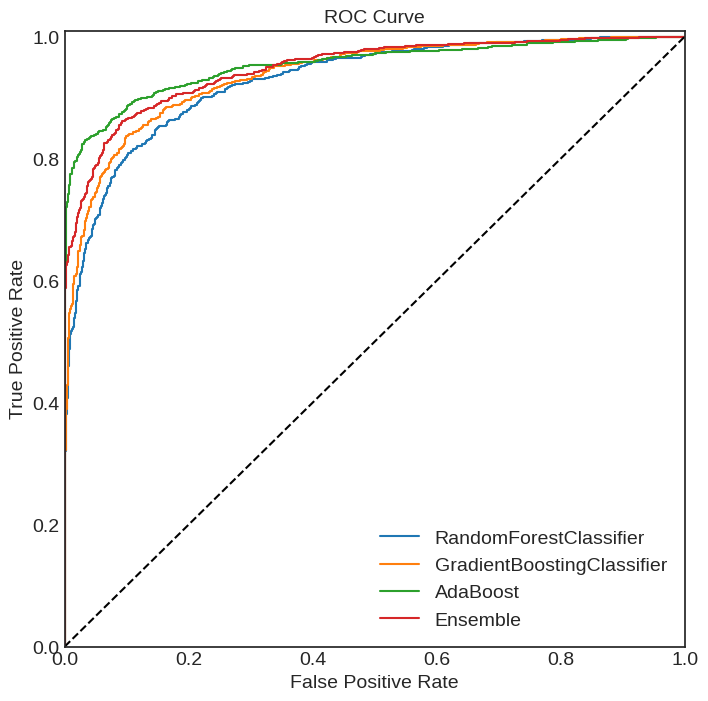

In [34]:
plot_roc_curves(df_preds, y_test_resampled)

### Bootstrap ROC Curve for AdaBoostClassifier

In [35]:
results = bootstrap_model(
    ada_clf,
    pd.DataFrame(selected_features), 
    pd.DataFrame(y_train_resampled), 
    pd.DataFrame(selected_features_test), 
    pd.DataFrame(y_test_resampled),
    10,   
    0.5
)

# Calculate accuracy from results
print(results)
accuracies = [metrics.accuracy_score(r['y_test'], r['y_pred']) for r in results['results']]


{'recall': [0.8550185873605948, 0.8475836431226765, 0.8438661710037175, 0.8522304832713755, 0.862453531598513, 0.8224907063197026, 0.8503717472118959, 0.8364312267657993, 0.8615241635687733, 0.8643122676579925], 'precision': [0.8949416342412452, 0.918429003021148, 0.899009900990099, 0.9151696606786427, 0.9106967615309126, 0.91995841995842, 0.9223790322580645, 0.9036144578313253, 0.9142011834319527, 0.9135559921414538], 'fscore': [0.8745247148288974, 0.8815853069115515, 0.8705656759348035, 0.8825794032723773, 0.8859188544152745, 0.8684985279685966, 0.8849129593810445, 0.8687258687258687, 0.8870813397129187, 0.8882521489971347], 'accuracy': [0.8773234200743495, 0.8861524163568774, 0.8745353159851301, 0.8866171003717472, 0.8889405204460966, 0.8754646840148699, 0.8894052044609665, 0.8736059479553904, 0.8903345724907064, 0.8912639405204461], 'fpr_tpr': [(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [36]:

total_auc = []
for r in results['fpr_tpr']:
    total_auc.append(metrics.auc(r[0], r[1]))



print("Accuracies from bootstrap results:", np.mean(accuracies))

Accuracies from bootstrap results: 0.883364312267658


### Bootstrap mean and empirical confidence intervals

In [37]:
np.mean(total_auc)

0.9433958727767721

In [38]:
pd.Series(total_auc).quantile([.025, .975])

0.025    0.931275
0.975    0.951813
dtype: float64

### Bootstrap ROC curve

In [39]:
df_interp = pd.DataFrame(roc_interp(results['fpr_tpr'])).T

In [40]:
m = df_interp.mean(axis=1).values.tolist()
ci = df_interp.quantile([.025, .975], axis=1).values.tolist()

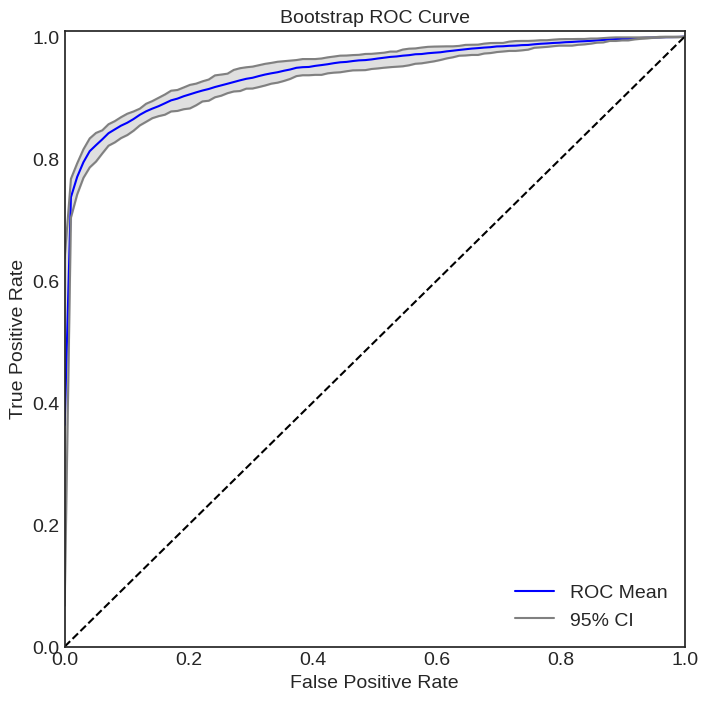

In [41]:
plot_bootstrap_roc(m, ci)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 50/50 [07:57<00:00,  9.55s/it]


Feature names: ['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity', 'Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0', 'Race_6.0', 'Race_7.0', 'Race_nan']


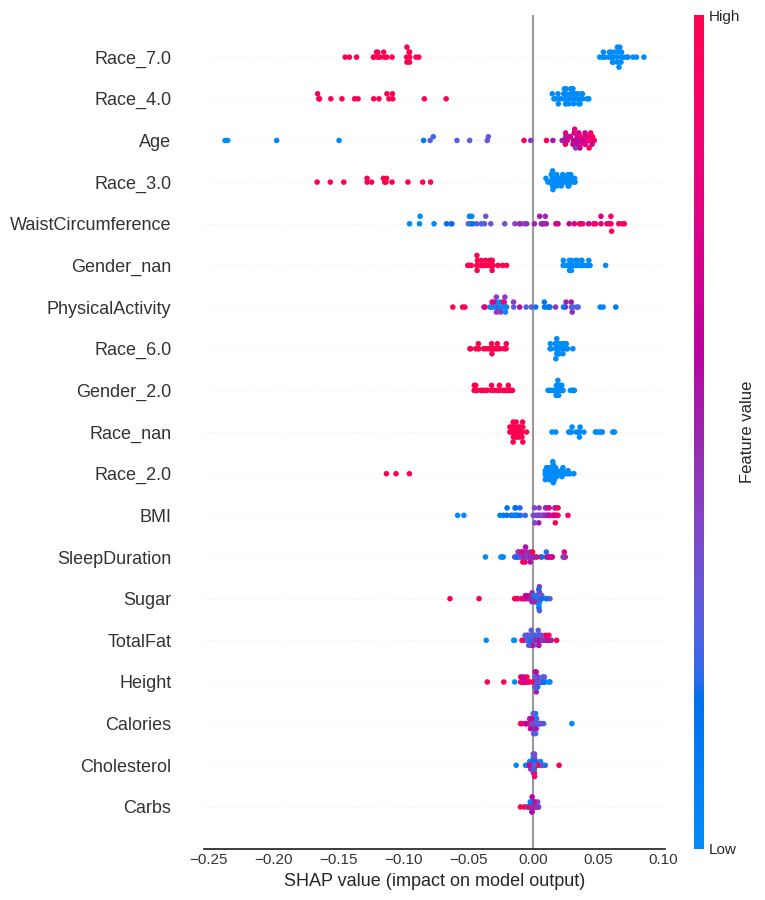

In [108]:
import shap
import numpy as np

class EnsembleModel:
    def __init__(self, models):
        """
        models: a list of fitted classifiers that implement .predict_proba(X)
        """
        self.models = models
    
    def predict_proba(self, X):
        """Return the average predicted probability across all models."""
        ensemble_probas = [m.predict_proba(X) for m in self.models]
        return np.mean(ensemble_probas, axis=0)


ensemble_clf = EnsembleModel([
    rf_clf,      # RandomForest
    # knn_clf,     # KNN
    # lg_clf,      # LogisticRegression
    # svc_clf,     # SVC
    gbc_clf,     # GradientBoosting
    ada_clf      # AdaBoost
])

np.random.seed(42)
background_size = 200
if selected_features.shape[0] > background_size:
    background_idx = np.random.choice(
        selected_features.shape[0], background_size, replace=False
    )
    background_data = selected_features[background_idx]
else:
    background_data = selected_features

explainer = shap.KernelExplainer(
    model=ensemble_clf.predict_proba,
    data=background_data,
)

test_sample_size = 50
if selected_features_test.shape[0] > test_sample_size:
    test_idx = np.random.choice(
        selected_features_test.shape[0], test_sample_size, replace=False
    )
    X_test_sample = selected_features_test[test_idx]
else:
    X_test_sample = selected_features_test

shap_values = explainer.shap_values(X_test_sample)

# selected_feature_names = [ for i in selected_indices]

feature_names = [X_train_pca.columns[i] for i in range(X_test_sample.shape[1])]

print("Feature names:", feature_names)

shap.summary_plot(
    shap_values[1], 
    X_test_sample, 
    feature_names=feature_names
)
